In [1]:
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot, uncertainty_plot, sorted_plot
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from mapie.regression import MapieRegressor

import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings('ignore')

# read in necessary material
folder = '/mnt/primus/xuemeng_tmp_harbour/soc'
test = pd.read_csv(f'{folder}/data/004.0_validate.pnts_oc.csv',low_memory=False)
# train = pd.read_csv(f'{folder}/data/005.0_train.pnts_oc.csv',low_memory=False)
train = pd.read_csv(f'{folder}/data/005.1_train.pnts_oc.org.mnr.csv',low_memory=False)

# covariates
# /SOC-EU/features/002_selected.covar_rank.freq.txt
with open(f'{folder}/SOC-EU/features/002.4_selected.covar,balanced_mnr.org.intersection.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]

# dataset
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

# spatial cross validation
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)
tgt = 'oc_log1p'

# score
from tool_kit import calc_ccc
from sklearn.metrics import make_scorer
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)

### build EML
- linear
- logistic

In [2]:
model_list = find_files(f'{folder}/SOC-EU/model/','*model*.joblib')
model_list = [str(i) for i in model_list]
# model_list = [i for i in model_list if 'weighted' not in i]
model_list = [i for i in model_list if 'balanced' in i]
model_list

['/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.mnr.balanced_rf.log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.org.balanced_rf.log1p.ccc.weighted.joblib']

In [3]:
from imblearn.over_sampling import SMOTE

y = train['oc_log1p'] > 5  # Target variable

# Apply SMOTE
smote = SMOTE(random_state=42)
train_balanced, y_resampled = smote.fit_resample(train[covs+[tgt]], y)


In [8]:
len(train_balanced.loc[train_balanced[tgt]>5])/len(train_balanced)

0.5

In [4]:
import time
from sklearn.ensemble import StackingRegressor

def build_EML(base_paths, meta_learner, data, covs, tgt, cv):
    base_models = []

    for path in base_paths:
        model_name = path.split('_')[-2].split('.')[-2] +'.'+ path.split('_')[-1][0:-7]
        model = joblib.load(path)
        base_models.append((model_name, model))


    reg = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner[1],
        cv=cv,
        n_jobs=90,
        passthrough=False
    )
    
    ttprint('start training')
    start_time = time.time()
    reg.fit(data[covs], data[tgt])
    end_time = time.time()
    training_time = (end_time - start_time)
    ttprint(f'finish training, use {training_time} s')
    
    combi = ''
    for im in base_models:
        combi = combi+'.'+im[0]
    combi = combi[1::]
    joblib.dump(reg, f'{folder}/SOC-EU/model/test_eml.{meta_learner[0]}_{combi}.joblib')
    return training_time

In [12]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression

combi_paths = [['/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.org.balanced_rf.log1p.ccc.weighted.joblib',
                '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.mnr.balanced_rf.log1p.ccc.weighted.joblib']]
ttime = []
for ipath in combi_paths:
    for imeta in [('gbr',GradientBoostingRegressor())]: # ,('enet',ElasticNet()),('ln',LinearRegression())
        tb = build_EML(ipath, imeta, train_balanced, covs, tgt, cv='prefit')
        ttime.append(tb)

[14:05:45] start training
[14:05:54] finish training, use 9.304650068283081 s


### evaluate EML
- linear
- logistic

In [15]:
model_list = find_files(f'{folder}/SOC-EU/model/','*eml*.joblib')
model_list = [str(i) for i in model_list]
# model_list = [i for i in model_list if 'weighted' not in i]
# model_list = [i for i in model_list if 'normal' in i]
model_list =[ '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_eml.gbr_org.rf.log1p.ccc.weighted.mnr.rf.log1p.ccc.weighted.joblib']

[14:08:16] evaluating eml.gbr_org.rf.log1p.ccc.weighted.mnr.rf.log1p.ccc.weighted on individual test dataset
[14:08:16] finish individual test prediction


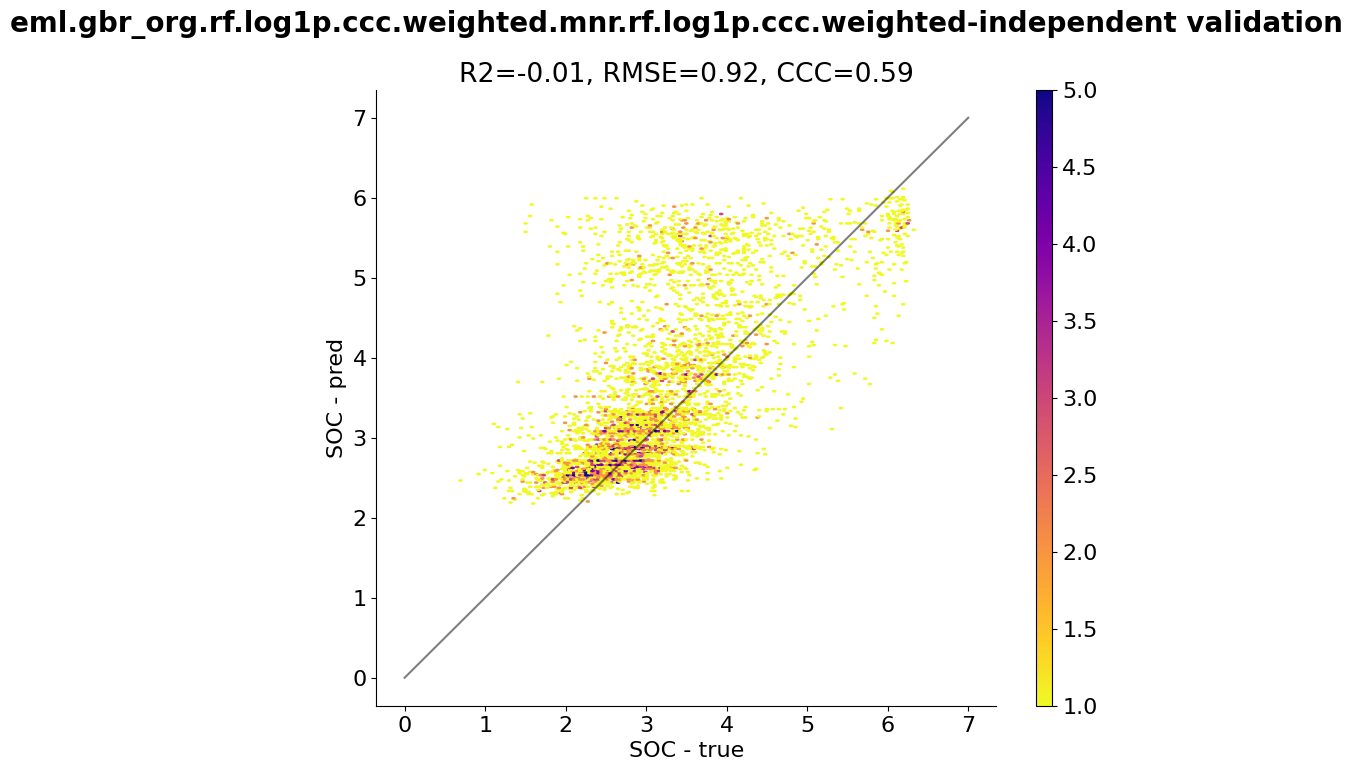

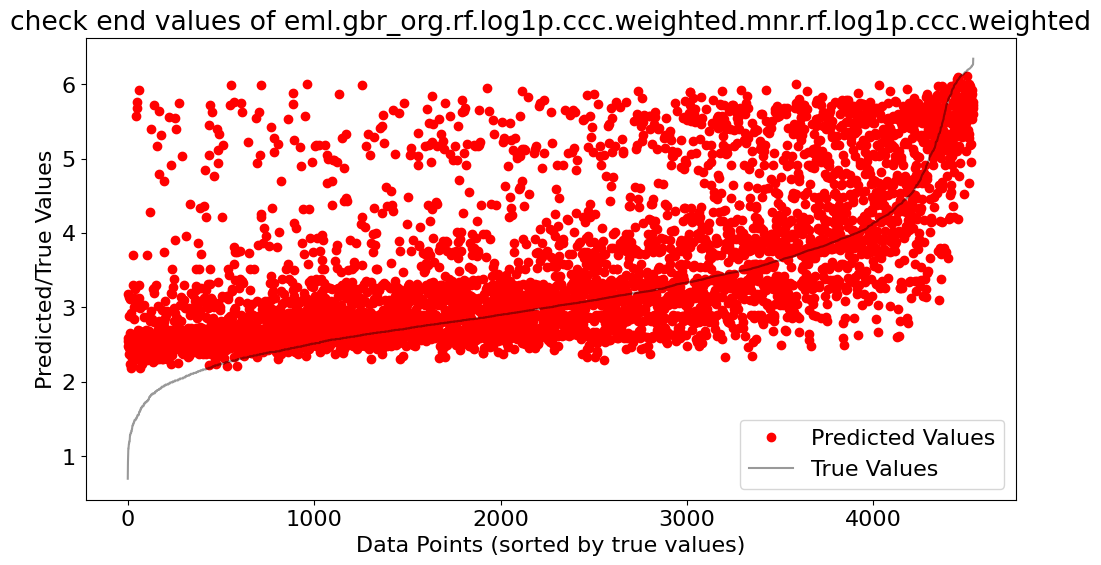

In [16]:
import time
results = []
for model_path in model_list:
    if 'eml' not in model_path:
        continue
    model_name = model_path.split('_')[-2] +'_'+ model_path.split('_')[-1][0:-7]
    model = joblib.load(model_path)
    
    if 'log1p' in model_path:
        tgt = 'oc_log1p'
    else:
        tgt = 'oc'
        
    ttprint(f'evaluating {model_name} on individual test dataset')
    start_time = time.time()
    y_pred_val = model.predict(test[covs])
    end_time = time.time()
    testing_time = (end_time - start_time)
    ttprint('finish individual test prediction')
    
    y_true = test[tgt]
    # if 'normal' in model_path:
    #     y_pred_val = np.log1p(y_pred_val)
    #     y_true = np.log1p(test[tgt])
    # else:
    #     y_true = test[tgt]
    
    r2_val, rmse_val, ccc_val = accuracy_plot(y_true, y_pred_val, model_name+ '-independent validation', vmax=5) # visuliazation
    # error_spatial_plot(y_true, y_pred_val, test['lat'], test['lon'], model_name)
    sorted_plot(y_true,y_pred_val,model_name)
    
    print()
    # ttprint(f'evaluating {model_name} with spatial CV')
    # y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train[spatial_cv_column], n_jobs=90)
    # r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name+ '-CV', vmax=20) # visuliazation
    # ttprint('finish CV')
    
    # Filter data for y > 5.02
    thres = 5.02
    y_true_gt = y_true[y_true > thres]
    y_pred_gt = y_pred_val[y_true > thres]
    
    # Filter data for y <= 5.02
    y_true_le = y_true[y_true <= thres]
    y_pred_le = y_pred_val[y_true <= thres]
    
    # Calculate metrics for y > 5.02
    r2_gt = r2_score(y_true_gt, y_pred_gt)
    rmse_gt = np.sqrt(mean_squared_error(y_true_gt, y_pred_gt))
    ccc_gt = calc_ccc(y_true_gt, y_pred_gt)
    
    # Calculate metrics for y <= 5.02
    r2_le = r2_score(y_true_le, y_pred_le)
    rmse_le = np.sqrt(mean_squared_error(y_true_le, y_pred_le))
    ccc_le = calc_ccc(y_true_le, y_pred_le)

    results.append({
        'title': model_name,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'R2_val_organic': r2_gt,
        'RMSE_val_organic': rmse_gt,
        'CCC_val_organic': ccc_gt,
        'R2_val_mineral': r2_le,
        'RMSE_val_mineral': rmse_le,
        'CCC_val_mineral': ccc_le,
        # 'train_time (s)': training_time,
        'predict_time (s)': testing_time
    })
    

In [17]:
results = pd.DataFrame(results)
results
# # results.to_csv(f'{folder}/SOC-EU/model/test_metrics_eml.csv', index=False)
# pre = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_eml/test_metrics_eml.csv')
# pre = pre.iloc[0:14]
# results = pd.concat([pre,results])
# results

,title,R2_val,RMSE_val,CCC_val,R2_val_organic,RMSE_val_organic,CCC_val_organic,R2_val_mineral,RMSE_val_mineral,CCC_val_mineral,predict_time (s)
0,eml.gbr_org.rf.log1p.ccc.weighted.mnr.rf.log1p...,-0.007784,0.916288,0.594933,-2.093296,0.704192,0.229886,-0.79267,0.926434,0.466932,0.754059


In [ ]:
results.to_csv(f'{folder}/SOC-EU/model/test_eml/test_metrics_eml.csv', index=False)

In [12]:
results['title'] = results['title'].str.replace('.log1p.ccc', '')
results

,title,R2_val,RMSE_val,CCC_val,R2_val_organic,RMSE_val_organic,CCC_val_organic,R2_val_mineral,RMSE_val_mineral,CCC_val_mineral,predict_time (s)
0,eml.ln_rf.cubist,0.529163,0.626016,0.723142,-11.880413,1.436961,0.050112,0.369892,0.548484,0.692623,65.589268
1,eml.enet_rf.cubist,0.387604,0.713948,0.452058,-27.858440,2.150882,0.009802,0.401693,0.534464,0.493107,67.419142
2,eml.gbr_rf.cubist,0.529990,0.625466,0.722842,-11.953077,1.441009,0.054927,0.372740,0.547243,0.690442,63.754907
3,eml.ln_rf.weighted.cubist,0.553090,0.609902,0.728958,-11.598727,1.421161,0.051189,0.408727,0.531313,0.700933,60.182423
4,eml.enet_rf.weighted.cubist,0.393853,0.710295,0.459577,-27.567452,2.140010,0.010050,0.407864,0.531700,0.500997,62.906775
5,eml.gbr_rf.weighted.cubist,0.545627,0.614974,0.728956,-11.346685,1.406874,0.056712,0.390401,0.539484,0.694114,64.563485
6,eml.ln_cubist.weighted.rf.weighted,0.468227,0.665294,0.695401,-13.785951,1.539589,0.044842,0.292702,0.581109,0.667273,45.765952
7,eml.enet_cubist.weighted.rf.weighted,0.399504,0.706977,0.471414,-27.337156,2.131367,0.010709,0.414042,0.528920,0.515174,44.978621
8,eml.gbr_cubist.weighted.rf.weighted,0.469475,0.664512,0.698273,-13.314329,1.514836,0.047609,0.286377,0.583701,0.666342,40.241922
9,eml.ln_rf.weighted.ann,0.520608,0.631677,0.699342,-13.659104,1.532971,0.041965,0.386674,0.541130,0.679534,0.238787


In [ ]:
results

In [33]:
ln = []
for ir in results['title'].unique().tolist():
    if 'rf.weighted' in ir:
        if 'enet' not in ir:
            if 'ann' not in ir:
                ln.append(ir)
        
results.loc[results['title'].isin(ln)]

,title,R2_val,RMSE_val,CCC_val,R2_val_organic,RMSE_val_organic,CCC_val_organic,R2_val_mineral,RMSE_val_mineral,CCC_val_mineral,predict_time (s)
3,eml.ln_rf.weighted.cubist,0.553090,0.609902,0.728958,-11.598727,1.421161,0.051189,0.408727,0.531313,0.700933,60.182423
5,eml.gbr_rf.weighted.cubist,0.545627,0.614974,0.728956,-11.346685,1.406874,0.056712,0.390401,0.539484,0.694114,64.563485
6,eml.ln_cubist.weighted.rf.weighted,0.468227,0.665294,0.695401,-13.785951,1.539589,0.044842,0.292702,0.581109,0.667273,45.765952
8,eml.gbr_cubist.weighted.rf.weighted,0.469475,0.664512,0.698273,-13.314329,1.514836,0.047609,0.286377,0.583701,0.666342,40.241922


In [14]:
results

,title,R2_val,RMSE_val,CCC_val,R2_val_organic,RMSE_val_organic,CCC_val_organic,R2_val_mineral,RMSE_val_mineral,CCC_val_mineral,predict_time (s)
0,eml.ln_rf.cubist,0.529163,0.626016,0.723142,-11.880413,1.436961,0.050112,0.369892,0.548484,0.692623,65.589268
1,eml.enet_rf.cubist,0.387604,0.713948,0.452058,-27.858440,2.150882,0.009802,0.401693,0.534464,0.493107,67.419142
2,eml.gbr_rf.cubist,0.529990,0.625466,0.722842,-11.953077,1.441009,0.054927,0.372740,0.547243,0.690442,63.754907
3,eml.ln_rf.weighted.cubist,0.553090,0.609902,0.728958,-11.598727,1.421161,0.051189,0.408727,0.531313,0.700933,60.182423
4,eml.enet_rf.weighted.cubist,0.393853,0.710295,0.459577,-27.567452,2.140010,0.010050,0.407864,0.531700,0.500997,62.906775
5,eml.gbr_rf.weighted.cubist,0.545627,0.614974,0.728956,-11.346685,1.406874,0.056712,0.390401,0.539484,0.694114,64.563485
6,eml.ln_cubist.weighted.rf.weighted,0.468227,0.665294,0.695401,-13.785951,1.539589,0.044842,0.292702,0.581109,0.667273,45.765952
7,eml.enet_cubist.weighted.rf.weighted,0.399504,0.706977,0.471414,-27.337156,2.131367,0.010709,0.414042,0.528920,0.515174,44.978621
8,eml.gbr_cubist.weighted.rf.weighted,0.469475,0.664512,0.698273,-13.314329,1.514836,0.047609,0.286377,0.583701,0.666342,40.241922
9,eml.ln_rf.weighted.ann,0.520608,0.631677,0.699342,-13.659104,1.532971,0.041965,0.386674,0.541130,0.679534,0.238787


In [13]:
results = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_metrics_eml.csv')
results['title'] = results['title'].str.replace('.log1p.ccc', '')

In [ ]:
import itertools
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot, uncertainty_plot
from sklearn.model_selection import cross_val_predict

# Load models
model_list = find_files(f'{folder}/SOC-EU/model/','0*model*.joblib')
model_list = [str(i) for i in model_list]
models = [joblib.load(path) for path in model_list]
model_names = ["rf", "lasso", "ann", "cubist"]
print(model_list)

# Generate all combinations of models (2, 3, and 4)
combinations = []
for r in range(2, 5):
    combinations.extend(itertools.combinations(zip(models, model_names), r))
    
# training dataset
sampled_train = train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 10))) # 44% data

results = []
# Loop through each combination of models
for combination in combinations:
    estimators = [(name, model) for model, name in combination]
    combi_name = ''
    for _, name in combination:
        combi_name = combi_name+' + '+name
    combi_name = combi_name[3::]
    if 'rf' not in combi_name:
        continue
    
    ttprint(f'fitting {combi_name}')
    # Define the Stacking Regressor
    stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression()
    )
    
    # Fit the stacking regressor
#     y_pred = cstacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression()
    )ross_val_predict(stacking_regressor, sampled_train[covs], sampled_train[tgt], cv=cv, groups=sampled_train[spatial_cv_column], n_jobs=90)  
    stacking_regressor.fit(sampled_train[covs], sampled_train[tgt])
    ttprint('finish fitting')
    y_pred = stacking_regressor.predict(test[covs])
    r2, rmse, ccc = accuracy_plot(test[tgt], y_pred, combi_name) # visuliazation
    error_spatial_plot(test[tgt], y_pred, test['lat'], test['lon'], combi_name)
    sorted_plot(test[tgt],y_pred,combi_name)
    
    # Store the results
    results.append({
        "Models": combi_name,
        "R2_CV": r2,
        "RMSE_CV": rmse,
        "CCC_CV": ccc
    })

# Create a DataFrame to store the results
results_df = pd.DataFrame(results)

results_df.to_csv(f'{folder}/SOC-EU/model/011_metrics_cv.eml.csv', index=False)
results_df